In [35]:
# Import necessary packages

import os 
import sys 
import pandas as pd
import numpy as np 
import pystan 
import matplotlib.pyplot as plt
import pickle
from datetime import datetime 
from scipy.stats import gaussian_kde
from hashlib import md5

In [11]:
#Assign each file a variable name
file1 = 'CustomerData.csv'

df = pd.read_csv(file1)

print(df.head())

      Name                 Email  TOTAL ORDERS NEW/Rep  ORDER #  Cohort  \
0  #7-1154  1rhondalee@gmail.com             2     new        1  14-Apr   
1    #4552  1rhondalee@gmail.com             2  repeat        2  14-Apr   
2    #3340      21csjs@gmail.com             3     new        1  14-Sep   
3   #14586      21csjs@gmail.com             3  repeat        2  14-Sep   
4   #14601      21csjs@gmail.com             3  repeat        3  14-Sep   

  Financial Status Fulfillment Status Accepts Marketing Currency  \
0             paid          fulfilled               yes      USD   
1             paid          fulfilled               yes      USD   
2             paid          fulfilled               yes      USD   
3             paid          fulfilled                no      USD   
4             paid          fulfilled                no      USD   

       ...        Total  Discount Amount                      Shipping Method  \
0      ...         15.0              0.0                   

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 23 columns):
Name                  2121 non-null object
Email                 2121 non-null object
TOTAL ORDERS          2121 non-null int64
NEW/Rep               2121 non-null object
ORDER #               2121 non-null int64
Cohort                2121 non-null object
Financial Status      2121 non-null object
Fulfillment Status    2121 non-null object
Accepts Marketing     2121 non-null object
Currency              2121 non-null object
Subtotal              2121 non-null float64
Shipping              2121 non-null int64
Taxes                 2121 non-null float64
Total                 2121 non-null float64
Discount Amount       2121 non-null float64
Shipping Method       2017 non-null object
Created at            2121 non-null object
MONTH                 2121 non-null object
YEAR                  2121 non-null int64
MON YEAR              2121 non-null object
Lineitem quantity     2121 non-nu

In [13]:
#Lets convert the date field into a datetime object: 

df['Created at'] = pd.to_datetime(df['Created at'])

#df['Created at'] = df['Created at'].dt.normalize()

In [14]:
#Total number of transactions
df.shape

(2121, 23)

In [15]:
#Number of customers : 

print (df.groupby(['Email']).size().shape)

(1168,)


In [16]:
# date range of the dataset: 

print (df['Created at'].min(), df['Created at'].max())

2014-04-01 15:41:00 2016-10-24 15:59:00


In [ ]:
# Time series of the number of transactions (daily) 

#ts_trans = df.groupby(['Created at']).size()
#plt.ylabel('Transaction Count') 
#ts_trans.plot()
#plt.show()


In [17]:
# Let's take a look at the typical inter-purchase time and IPT distribution 

def shift_date(x): 
    x['shifted_date'] = x['Created at'].shift(-1) 
    return x

# We'll apply a shift of -1 between the 'date' column and a newly shifted date column shift_date. 
# That way, we'll be able to subtract date from shifted_date at the customer level and compute 
# the inter purchase time (IPT) directly : 
transactions_tmp = df.sort_values(['Created at']).groupby(['Email'], as_index=True).apply(shift_date)    

# Let's re-order by customer and date : 
transactions_tmp.sort_values(['Email','Created at'], ascending=True, inplace=True)
transactions_tmp.dropna(inplace=True)


# Compute the IPT in days : 
transactions_tmp['IPT'] = (transactions_tmp['shifted_date'] - transactions_tmp['Created at']).apply(lambda x : x.days)

transactions_tmp.head(50)

,Name,Email,TOTAL ORDERS,NEW/Rep,ORDER #,Cohort,Financial Status,Fulfillment Status,Accepts Marketing,Currency,...,Shipping Method,Created at,MONTH,YEAR,MON YEAR,Lineitem quantity,Lineitem name,Lineitem price,shifted_date,IPT
2,#3340,21csjs@gmail.com,3,new,1,14-Sep,paid,fulfilled,yes,USD,...,Standard Ground (3-7 business days),2014-09-14 07:56:00,Sep,2014,14-Sep,1,women's kade cargo scrub pants - graphite - XS,40.0,2015-11-27 05:44:00,438
3,#14586,21csjs@gmail.com,3,repeat,2,14-Sep,paid,fulfilled,no,USD,...,Standard Ground (3-7 business days),2015-11-27 05:44:00,Nov,2015,15-Nov,1,women's kalo pouch-pocket scrub top - limeston...,30.0,2015-11-27 05:54:00,0
5,#2764,24.aahmed@gmail.com,3,new,1,14-Jul,paid,fulfilled,yes,USD,...,Standard Ground (3-7 business days),2014-07-14 15:41:00,Jul,2014,14-Jul,1,men's eldoret basic scrub pants - cement - L,30.0,2014-07-29 15:39:00,14
6,#2916,24.aahmed@gmail.com,3,repeat,2,14-Jul,paid,fulfilled,no,USD,...,Standard Ground (3-7 business days),2014-07-29 15:39:00,Jul,2014,14-Jul,1,men's leon one-pocket scrub top - black - L,30.0,2014-08-10 06:08:00,11
10,#2800,81lomac@gmail.com,3,new,1,14-Jul,partially_refunded,fulfilled,yes,USD,...,Standard Ground (3-7 business days),2014-07-17 17:23:00,Jul,2014,14-Jul,1,women's livingston basic scrub pants - royal b...,35.0,2015-02-14 06:54:00,211
11,#4515,81lomac@gmail.com,3,repeat,2,14-Jul,refunded,fulfilled,yes,USD,...,Standard Ground (3-7 business days),2015-02-14 06:54:00,Feb,2015,15-Feb,1,women's dakar basic scrub pants - navy - M,30.0,2015-02-21 08:01:00,7
85,#2642,AlisonTFreeman@gmail.com,4,repeat,3,14-Jun,paid,fulfilled,yes,USD,...,Standard Ground (3-7 business days),2014-06-30 19:42:00,Jun,2014,14-Jun,5,women's livingston basic scrub pants - black - XL,35.0,2014-08-14 19:29:00,44
417,#3987,CTHOMASMD@YAHOO.COM,3,repeat,2,14-Aug,paid,fulfilled,yes,USD,...,Standard Ground (3-7 business days) - Will shi...,2014-12-28 09:01:00,Dec,2014,14-Dec,1,men's eldoret basic scrub pants - black - M,30.0,2015-01-05 07:01:00,7
301,#2645,CaseyEMartin13@gmail.com,2,new,1,14-Jul,paid,fulfilled,yes,USD,...,Standard Ground (3-7 business days),2014-07-01 00:32:00,Jul,2014,14-Jul,1,women's kade cargo scrub pants - navy - L,40.0,2014-07-10 23:19:00,9
333,#3200,ChristenHalleyHughes@gmail.com,2,new,1,14-Aug,paid,fulfilled,no,USD,...,Standard Ground (3-7 business days),2014-08-27 15:52:00,Aug,2014,14-Aug,1,women's livingston basic scrub pants - ceil bl...,35.0,2014-10-09 03:37:00,42


In [18]:
# let's print the mean IPT. Our training period of 365 days is long enough. 

print(transactions_tmp['IPT'].mean())

145.8513661202186


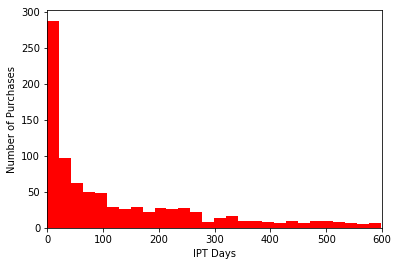

In [19]:
# Distribution of IPT : 

_ = plt.hist(transactions_tmp['IPT'], bins= 40, color='r')
_ = plt.xlabel('IPT Days')
_ = plt.ylabel('Number of Purchases')
_ = plt.xlim([0,600])
plt.show()

1 15


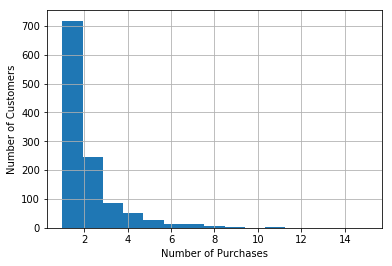

In [20]:
# Let's look at the distribution of the number of purchases per customer:

n_purchases = df.groupby(['Email']).size()
print(n_purchases.min(axis=0), n_purchases.max(axis=0))
n_purchases.hist(bins=(n_purchases.max(axis=0) - n_purchases.min(axis=0)) + 1)
plt.xlabel('Number of Purchases') 
plt.ylabel('Number of Customers')
plt.show()

In [21]:
# Select calibration and holdout periods # Select  
# Lets select a training period of one year and and a holdout period of 6 months. 

df['end_date'] = '09/30/2015 23:59:59'
df['end_date'] = pd.to_datetime(df['end_date'], format='%m/%d/%Y %H:%M:%S')
train = df[df['Created at'] <= df['end_date']]
holdout = df[df['Created at'] > df['end_date']]

In [22]:
#Sum the monetary value by customer and by date:
train2 = train.sort_values(['Created at'], ascending = True).groupby(['Email', 'Created at'], as_index=False)['Subtotal'].sum()

In [23]:
train2.head()

,Email,Created at,Subtotal
0,1rhondalee@gmail.com,2014-04-15 09:42:00,15.0
1,1rhondalee@gmail.com,2015-02-16 18:30:00,65.0
2,21csjs@gmail.com,2014-09-14 07:56:00,72.0
3,24.aahmed@gmail.com,2014-07-14 15:41:00,55.0
4,24.aahmed@gmail.com,2014-07-29 15:39:00,65.0


In [24]:
# let's define a single function that can be applied at the customer level and # let's d 
# compute all the relevant RFM quantities at once : 

end_calibration = pd.to_datetime('2015-09-30 23:59:59')

def compute_rfm(x, end_calibration): 
    x['recency'] = (x['Created at'].max() - x['Created at'].min()).days
    x['frequency'] = x['Created at'].count()-1
    x['T'] = (end_calibration - x['Created at'].min()).days
    x['monetary_value'] = x['Subtotal'].mean()
    return x

In [25]:
# use the function compute_rfm to compute recency, frequency, T and monetary value 
# for each group (each customer). 

train3 = train2.groupby(['Email']).apply(lambda x: compute_rfm(x, end_calibration))

In [26]:
train3.head()

,Email,Created at,Subtotal,recency,frequency,T,monetary_value
0,1rhondalee@gmail.com,2014-04-15 09:42:00,15.0,307,1,533,40.0
1,1rhondalee@gmail.com,2015-02-16 18:30:00,65.0,307,1,533,40.0
2,21csjs@gmail.com,2014-09-14 07:56:00,72.0,0,0,381,72.0
3,24.aahmed@gmail.com,2014-07-14 15:41:00,55.0,26,2,443,49.0
4,24.aahmed@gmail.com,2014-07-29 15:39:00,65.0,26,2,443,49.0


In [27]:
# lets take the first row for each customer and only the relevant columns of interest. 

rfm = train3[['Email', 'recency', 'frequency', 'T', 'monetary_value']].groupby(['Email']).first()

In [28]:
rfm.head()

,recency,frequency,T,monetary_value
Email,,,,
1rhondalee@gmail.com,307,1,533,40.0
21csjs@gmail.com,0,0,381,72.0
24.aahmed@gmail.com,26,2,443,49.0
2jill.richter@gmail.com,0,0,507,20.0
4evercountrygirl@gmail.com,0,0,507,60.0


In [29]:
# Let's look at the range of values for each column. Make sure the results make sense 
# before going any further with the analysis. No NaNs, 
# no negative values, no recency > 364 days, etc.  

rfm.describe()

,recency,frequency,T,monetary_value
count,1163.000000,1163.000000,1163.000000,1163.000000
mean,54.375752,0.603611,457.654342,81.849677
std,113.571941,1.149820,54.007594,55.153298
min,0.000000,0.000000,72.000000,17.600000
25%,0.000000,0.000000,414.000000,55.000000
50%,0.000000,0.000000,460.000000,65.000000
75%,21.000000,1.000000,504.000000,95.000000
max,510.000000,10.000000,547.000000,660.666667


In [36]:
# Training the STAN model over several 1000's iterations can take a long time. 
# I recommend running the STAN models for at least 5000 iterations with a warmup 
# of a few 100. To get a thorough understanding of the code below and the fit results, 
# I highly recommend reading the STAN documentation. 

# Although running a STAN model is not necessary to solve a Pareto/NBD model, 
# it allows you to extend/change the model with ease. 

paretonbd_model="""
data{
int<lower=0> n_cust; //number of customers 
vector<lower=0>[n_cust] x; 
vector<lower=0>[n_cust] tx; 
vector<lower=0>[n_cust] T; 
}

parameters{
// vectors of lambda and mu for each customer. 
// Here I apply limits between 0 and 1 for each 
// parameter. A value of lambda or mu > 1.0 is unphysical 
// since you don't enough time resolution to go less than 
// 1 time unit. 
vector <lower=0,upper=1.0>[n_cust] lambda; 
vector <lower=0,upper=1.0>[n_cust] mu;

// parameters of the prior distributions : r, alpha, s, beta. 
// for both lambda and mu
real <lower=0>r;
real <lower=0>alpha;
real <lower=0>s;
real <lower=0>beta;
}

model{

// temporary variables : 
vector[n_cust] like1; // likelihood
vector[n_cust] like2; // likelihood 

// Establishing hyperpriors on parameters r, alpha, s, and beta. 
r ~ normal(0.5,0.1);
alpha ~ normal(10,1);
s ~ normal(0.5,0.1);
beta ~ normal(10,1);

// Establishing the Prior Distributions for lambda and mu : 
lambda ~ gamma(r,alpha); 
mu ~ gamma(s,beta);

// The likelihood of the Pareto/NBD model : 
like1 = x .* log(lambda) + log(mu) - log(mu+lambda) - tx .* (mu+lambda);
like2 = (x + 1) .* log(lambda) - log(mu+lambda) - T .* (lambda+mu);

// Here we increment the log probability density (target) accordingly 
target+= log(exp(like1)+exp(like2));
}
"""

# here's the data we will provide to STAN : 
data={'n_cust':len(rfm),
    'x':rfm['frequency'].values,
    'tx':rfm['recency'].values,
    'T':rfm['T'].values
}

In [37]:
# STAN models can take a while to fit. Let's pickle the model to disk as a precautionary measure. 
# We can always read the model from disk later on. Note that this file is sizable > 100 MB. 

# Utility function to pull a stan model that has been pickled. 
# from pystan docs : https://pystan.readthedocs.io/en/latest/avoiding_recompilation.html
def stan_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm.sampling(**kwargs)

iterations = 1000
warmup = 500

# I recommend training for several 1000's iterations. Here we run the STAN model : 
pareto_nbd_fit = stan_cache(paretonbd_model, model_name='paretonbd_model', \
                                  data=data, chains=1, iter=iterations, warmup=warmup)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_76111598b747c5ab299e594dcfa74504 NOW.


In [38]:
# Here we'll extract the traces for the lambda and mu parameters. We get the posterior 
# distribution of these parameters for "free" when using STAN. 

trace = pareto_nbd_fit.extract()
lambdas = trace['lambda']
mus = trace['mu']

In [39]:
# Here I take the expectation (mean) value of E[X(t) | lambda, mu] over the trace values of lambda and mu: 

dt_train = 365.0 # 12 months 
training_predictions = (lambdas/mus-lambdas/mus*np.exp(-mus*dt_train)).mean(axis=0)
rfm['model_train_count'] = training_predictions

In [40]:
rmse_train_count = (rfm['model_train_count'] - rfm['frequency']).apply(lambda x : x*x)
rmse_train_count = np.sqrt(rmse_train_count.sum()/len(rfm))
print('RMSE =', rmse_train_count)

RMSE = 0.459540659793


In [41]:
def plot_scatter(dataframe, colx, coly, xlabel='Observed Counts', 
                 ylabel='Predicted Counts', 
                 xlim=[0,15], ylim=[0,15], density=True): 
    """This function will plot a scatter plot of colx on the x-axis vs coly on the y-axis. 
    If you want to add a color to indicate the density of points, set density=True
    
    Args : 
        - dataframe (dataframe) : pandas dataframe containing the data of interest 
        - colx (str) : name of the column you want to put on the x axis 
        - coly (str) : same but for the y axis 
        - xlabel (str) : label to put on the x axis 
        - ylabel (str) : same for y axis 
        - xlim (list) : defines the range of x values displayed on the chart 
        - ylim (list) same for the y axis. 
        - density (bool) : set True to add color to indicate density of point. 
        
    """

    if not density : 
        plt.scatter(dataframe[colx].values, dataframe[coly].values)
    else:
        xvals = dataframe[colx].values
        yvals = dataframe[coly].values
        xy = np.vstack([xvals, yvals])
        z = gaussian_kde(xy)(xy)
        plt.scatter(xvals, yvals, c=z, s=10, edgecolor='')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(np.linspace(xlim[0], xlim[1], 100), 
             np.linspace(ylim[0], ylim[1], 100), 
             color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.plot()
    plt.show()

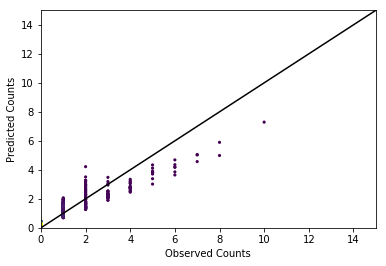

In [42]:
# Let's see the scatter plot predicted vs observed purchase counts in the training period.

plot_scatter(rfm, 'frequency', 'model_train_count')

In [43]:
def prob_alive_at_T(lam, mu, t_x, T): 
    """Computes the probability of being alive at T given lambda, mu, t_x, and T"""
    return 1 / ( 1 + mu / (mu + lam) * (np.exp((lam + mu) * (T - t_x)) - 1) )

In [44]:
# Predictions made over the holdout period of 1 year: 
dt_hold = 365.0 # 1 months 

# Here we extract recency and T values: 
tmp = rfm['T'].values 
T_values = np.tile(tmp, [iterations - warmup, 1])
tmp2 = rfm['recency'].values 
recency_values = np.tile(tmp2, [iterations - warmup, 1])

# Holdout counts predictions : 
holdout_predictions = ((lambdas/mus - lambdas/mus*np.exp(-mus*dt_hold)) * \
                                prob_alive_at_T(lambdas, mus, recency_values, T_values)).mean(axis=0)

#holdout_predictions = (lambdas/mus - lambdas/mus*np.exp(-mus*dt_hold)) * prob_alive_at_t(lambdas, mus, t_x, T)
rfm['model_holdout_count'] = np.asarray(holdout_predictions)

In [46]:
# lets look at the observed number of transactions during the same time period : 
# counts per customer per date : 
holdout_counts = holdout.groupby(['Email', 'Created at'], as_index=False).size().reset_index()

# counts per customer : 
holdout_counts = holdout_counts.groupby(['Email']).size()

# Let's merge with the rfm object. 
rfm_with_holdout = rfm.merge(pd.DataFrame(holdout_counts), how='left', left_index=True, right_index=True)
rfm_with_holdout.rename(columns={0:'obs_holdout_count'}, inplace=True)
rfm_with_holdout.fillna(0, inplace=True)

RMSE = 0.68431844949


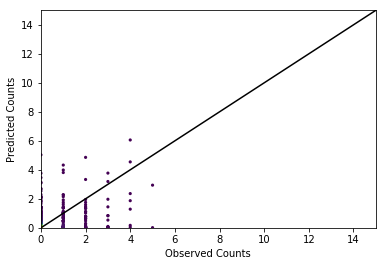

In [47]:
# Let's now plot the data : 

rmse_holdout_count=(rfm_with_holdout['model_holdout_count'] - rfm_with_holdout['obs_holdout_count']).apply(lambda x :x*x)
rmse_holdout_count=np.sqrt(rmse_holdout_count.sum()/len(rfm_with_holdout))
print('RMSE =', rmse_holdout_count)
plot_scatter(rfm_with_holdout, 'obs_holdout_count', 'model_holdout_count')
plt.show()

In [48]:
# This gamma-gamm model follows the Fader et al. (2004) Gamma-Gamma model closely. 
# Again, this model can take a while to train. Recommend a few 1000's iterations. 

gamma_gamma_model="""
data {
    // this is the data we pass to STAN : 
    int<lower=1> n_cust;         // number of customers 
    vector[n_cust] x;            // frequency + 1 
    vector[n_cust] mx;           // average purchase amount for each customer 
}

parameters {
    // These are the model parameters : 
    real <lower=0>p;             // scale parameter of the gamma distribution. Note that 
                                 // this parameter is not a vector. All customers will have the 
                                 // same value of p. 
    vector<lower=0> [n_cust] v;   // shape parameter of the gamma distribution (nu)
    real <lower=0>q;             // shape parameter of the gamma prior distribtion on v 
    real <lower=0>y;             // scale parameter of the gamma prior distribution on v 
}

transformed parameters {
    vector<lower=0> [n_cust] px;
    vector<lower=0> [n_cust] nx; 
    px <- p * x;                 // getting px from p and x 
    for (i in 1:n_cust) 
        nx[i] <- v[i] * x[i]; 
}

model {
    p ~ exponential(0.1);    // prior distribution on p
    q ~ exponential(0.5);    // hyperprior distribution on q 
    y ~ exponential(0.1);    // hyperprior distribution on y 
//    v ~ gamma(q, q ./ y);    // prior distribution on nu  
//    mx ~ gamma(px, v);       // likelihood function 
    v ~ gamma(q,y); 
    mx ~ gamma(px,nx); 
}
"""

# here's the data we will provide to STAN : 
data_gg={'n_cust':len(rfm),
    'x':rfm['frequency'].values+1.0,
    'mx':rfm['monetary_value'].values
     }

# I recommend training for several 1000's iterations. 
gamma_gamma_fit = stan_cache(gamma_gamma_model, model_name='gamma_gamma_model', \
                                  data=data_gg, chains=1, iter=1000, warmup=500)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4924349d364d7044bdbeb8d56b0e2fc3 NOW.


In [49]:
# Here I extract the model parameters from the fit # Here I  

trace_gg = gamma_gamma_fit.extract()
nu = trace_gg['v']
p = trace_gg['p']
gamma = trace_gg['y']
q = trace_gg['q']

In [50]:
# Now let's compute E(M) and join it to the rfm object :# Now let 
pvalues = np.tile(np.array(p).T,(len(rfm),1))
E_M = (pvalues / nu.T).mean(axis=1)

In [51]:
# Now let's compute E(M) and join it to the rfm object : 

rfm['E_M'] = E_M

In [52]:
rfm[['monetary_value', 'E_M']].head()

,monetary_value,E_M
Email,,
1rhondalee@gmail.com,40.0,42.766486
21csjs@gmail.com,72.0,72.846681
24.aahmed@gmail.com,49.0,50.464081
2jill.richter@gmail.com,20.0,26.986063
4evercountrygirl@gmail.com,60.0,62.369247


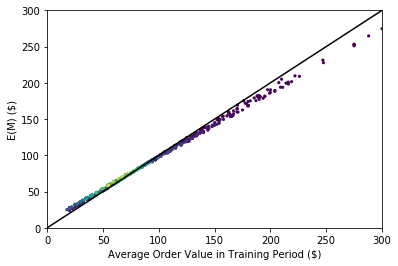

In [56]:
# Let's explore the results : 

plot_scatter(rfm,'monetary_value','E_M', 
             xlabel='Average Order Value in Training Period ($)', 
             ylabel='E(M) ($)', 
             xlim=[0,300], ylim=[0,300])

plt.show()

In [60]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 3 to 2112
Data columns (total 24 columns):
Name                  256 non-null object
Email                 256 non-null object
TOTAL ORDERS          256 non-null int64
NEW/Rep               256 non-null object
ORDER #               256 non-null int64
Cohort                256 non-null object
Financial Status      256 non-null object
Fulfillment Status    256 non-null object
Accepts Marketing     256 non-null object
Currency              256 non-null object
Subtotal              256 non-null float64
Shipping              256 non-null int64
Taxes                 256 non-null float64
Total                 256 non-null float64
Discount Amount       256 non-null float64
Shipping Method       249 non-null object
Created at            256 non-null datetime64[ns]
MONTH                 256 non-null object
YEAR                  256 non-null int64
MON YEAR              256 non-null object
Lineitem quantity     256 non-null int64
Linei

In [96]:
# Let's compute the observed mean transaction value per customer in the holdout period : 

holdout_value = holdout.groupby(['Email'], as_index=True)['Subtotal'].mean()
#holdout_value = holdout_value[['cust', 'sales']].groupby(['cust'])['sales'].mean()
holdout_value=pd.DataFrame(holdout_value)
holdout_value.rename(columns={'Subtotal':'obs_holdout_monetary_value'}, inplace=True)
holdout_value.head()

,obs_holdout_monetary_value
Email,
21csjs@gmail.com,43.55
JANEROWELL@YMAIL.COM,181.00
Maderof04@yahoo.com,40.00
Wrighttl@ah.org,70.00
acclinic@gmail.com,130.00


In [100]:
# merge with rfm object : # merge w 
rfm_w_holdout_value  = rfm.merge(holdout_value, how='left', left_index=True, right_index=True)
rfm_w_holdout_value['obs_holdout_monetary_value'].fillna(0,inplace=True)

rfm_w_holdout_value.head()

,recency,frequency,T,monetary_value,model_train_count,model_holdout_count,E_M,obs_holdout_monetary_value
Email,,,,,,,,
1rhondalee@gmail.com,307,1,533,40.0,0.733806,0.579100,42.766486,0.00
21csjs@gmail.com,0,0,381,72.0,0.256400,0.040300,72.846681,43.55
24.aahmed@gmail.com,26,2,443,49.0,2.877356,0.006298,50.464081,0.00
2jill.richter@gmail.com,0,0,507,20.0,0.239162,0.022281,26.986063,0.00
4evercountrygirl@gmail.com,0,0,507,60.0,0.300309,0.018439,62.369247,0.00


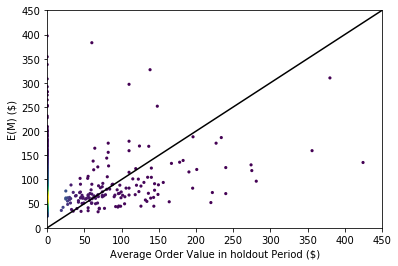

In [103]:
plot_scatter(rfm_w_holdout_value,'obs_holdout_monetary_value','E_M', 
             xlabel='Average Order Value in holdout Period ($)', 
             ylabel='E(M) ($)', 
             xlim=[0,450], ylim=[0,450])
plt.show()

In [104]:
rfm['E_M'].mean()

81.86143175025686

In [105]:
holdout_value.mean()

obs_holdout_monetary_value    103.942743
dtype: float64

In [106]:
# compute both modeled and observed CLV in the holdout period : 

rfm['model_holdout_clv'] = rfm_with_holdout['model_holdout_count'] * rfm['E_M']
rfm['obs_holdout_clv'] = rfm_with_holdout['obs_holdout_count'] * rfm_w_holdout_value['obs_holdout_monetary_value']
rmse_holdout_clv = (rfm['model_holdout_clv'] - rfm['obs_holdout_clv'])* \
                   (rfm['model_holdout_clv'] - rfm['obs_holdout_clv'])
rmse_holdout_clv = np.sqrt(rmse_holdout_clv.sum()/len(rfm))

RMSE = 92.6459576566


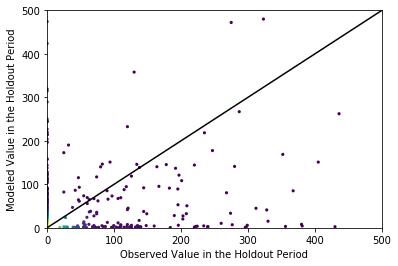

In [107]:
# plot the final results : # plot th 
print('RMSE =', rmse_holdout_clv)
plot_scatter(rfm, 'obs_holdout_clv', 'model_holdout_clv',
             xlabel='Observed Value in the Holdout Period',
             ylabel='Modeled Value in the Holdout Period', 
             xlim=[0,500.0],ylim=[0,500.0])
plt.show()